In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
payments = pd.read_csv('dstakehome_payments.csv')
merchants = pd.read_csv('dstakehome_merchants.csv')

In [50]:
# Preview the first few rows of each dataset
payments_preview = payments.head()
merchants_preview = merchants.head()

# Get basic info about the datasets
payments_info = payments.info()
merchants_info = merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1577887 entries, 0 to 1577886
Data columns (total 7 columns):
 #   Column                   Non-Null Count    Dtype              
---  ------                   --------------    -----              
 0   date                     1577887 non-null  datetime64[ns, UTC]
 1   merchant                 1577887 non-null  object             
 2   subscription_volume      1577887 non-null  int64              
 3   checkout_volume          1577887 non-null  int64              
 4   payment_link_volume      1577887 non-null  int64              
 5   total_volume             1577887 non-null  int64              
 6   non_subscription_volume  1577887 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(5), object(1)
memory usage: 84.3+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 23601 entries, 0 to 23626
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------

In [56]:
# Convert date fields to datetime with error handling
payments['date'] = pd.to_datetime(payments['date'], errors='coerce')
merchants['first_charge_date'] = pd.to_datetime(merchants['first_charge_date'], errors='coerce')

# Exclude invalid dates (null) from merchants dataset. n = 26 excluded
merchants = merchants[merchants['first_charge_date'].notna()]

In [59]:
# Replace '0' in the industry column with 'Unknown'
merchants['industry'] = merchants['industry'].replace('0', 'Unknown')

# Confirm it worked
unique_industries = merchants['industry'].unique()

unique_industries

array(['Education', 'Others', 'Software', 'Business services',
       'Electronics', 'Personal services', 'Digital goods',
       'Religion, politics & other memberships', 'Merchandise',
       'Grocery & food stores', 'Clothing & accessory', 'Leisure',
       'Food & drink', 'Charity',
       'Automotive parts and repair/service shops', 'Construction',
       'Art & photography', 'Travel & lodging', 'Specialty retail',
       'Ticketing & events',
       'Medical services, drugs, testing labs & equipment medium',
       'Healthcare', 'Cosmetics', 'Furnishing', 'Rentals',
       'Consulting services', 'Transportation & car rental', 'Insurance',
       'Money transmitters', 'Unknown'], dtype=object)

In [62]:
# Convert 'merchant' to string and strip whitespace
payments['merchant'] = payments['merchant'].astype(str).str.strip()
merchants['merchant'] = merchants['merchant'].astype(str).str.strip()

payments_clean = payments
merchants_clean = merchants

# # Define a regex pattern that matches scientific notation
# sci_notation_pattern = re.compile(r'^\d+(\.\d+)?[eE][+-]?\d+$')

# # Filter out merchants with scientific notation format
# payments_clean = payments[~payments['merchant'].str.match(sci_notation_pattern)]
# merchants_clean = merchants[~merchants['merchant'].str.match(sci_notation_pattern)]

# Confirm counts after exclusion
payments_count = payments_clean['merchant'].nunique()
merchants_count = merchants_clean['merchant'].nunique()

payments_count, merchants_count

(23619, 23593)

In [68]:
final_data = _dntk.execute_sql(
  'WITH max_date AS (\n  SELECT MAX(date::DATE) AS latest_date FROM payments_clean\n),\n\npayments_with_non_sub_volume AS (\n  SELECT\n    merchant,\n    date,\n    subscription_volume,\n    checkout_volume,\n    payment_link_volume,\n    total_volume,\n    (checkout_volume + payment_link_volume) AS non_subscription_volume\n  FROM payments_clean\n),\n\nrfm_raw AS (\n  SELECT\n    p.merchant,\n    MAX(CASE WHEN p.non_subscription_volume > 0 THEN p.date ELSE NULL END) AS last_transaction_date,\n    COUNT(DISTINCT CASE WHEN p.date >= md.latest_date - INTERVAL \'180 day\' AND p.non_subscription_volume > 0 THEN p.date END) AS frequency_days_180,\n    SUM(CASE WHEN p.date >= md.latest_date - INTERVAL \'180 day\' AND p.non_subscription_volume > 0 THEN p.non_subscription_volume ELSE 0 END) AS monetary_180\n  FROM payments_with_non_sub_volume p\n  CROSS JOIN max_date md\n  GROUP BY p.merchant\n),\n\nsub_status AS (\n  SELECT\n    m.merchant,\n    m.business_size,\n    m.industry,\n    m.first_charge_date,\n    m.country,\n    md.latest_date,\n    DATE_DIFF(\'month\', m.first_charge_date::DATE, md.latest_date) AS tenure_months,\n    CASE WHEN SUM(p.subscription_volume) > 0 THEN 1 ELSE 0 END AS subscription_status,\n    CASE WHEN SUM(p.checkout_volume) > 0 THEN 1 ELSE 0 END AS used_checkout,\n    CASE WHEN SUM(p.payment_link_volume) > 0 THEN 1 ELSE 0 END AS used_payment_link,\n    SUM(p.subscription_volume) AS subscription_volume_lifetime,\n    SUM(p.checkout_volume) AS checkout_volume_lifetime,\n    SUM(p.payment_link_volume) AS payment_link_volume_lifetime,\n    SUM(p.total_volume) AS total_volume_lifetime,\n    SUM(p.non_subscription_volume) AS non_subscription_volume_lifetime,\n    SUM(CASE WHEN p.date < (md.latest_date - INTERVAL \'30 day\') THEN p.total_volume ELSE 0 END) AS prior_volume,\n    SUM(CASE WHEN p.date >= (md.latest_date - INTERVAL \'30 day\') THEN p.total_volume ELSE 0 END) AS total_volume_30d,\n    SUM(CASE WHEN p.date >= (md.latest_date - INTERVAL \'30 day\') THEN p.subscription_volume ELSE 0 END) AS subscription_volume_30d,\n    SUM(CASE WHEN p.date >= (md.latest_date - INTERVAL \'30 day\') THEN p.checkout_volume ELSE 0 END) AS checkout_volume_30d,\n    SUM(CASE WHEN p.date >= (md.latest_date - INTERVAL \'30 day\') THEN p.payment_link_volume ELSE 0 END) AS payment_link_volume_30d,\n    SUM(CASE WHEN p.date >= (md.latest_date - INTERVAL \'30 day\') THEN p.non_subscription_volume ELSE 0 END) AS non_subscription_volume_30d,\n    CASE\n      WHEN SUM(p.total_volume) - SUM(CASE WHEN p.date >= (md.latest_date - INTERVAL \'30 day\') THEN p.total_volume ELSE 0 END) > 0\n      THEN ROUND(SUM(CASE WHEN p.date >= (md.latest_date - INTERVAL \'30 day\') THEN p.total_volume ELSE 0 END) / \n                 NULLIF(SUM(p.total_volume) - SUM(CASE WHEN p.date >= (md.latest_date - INTERVAL \'30 day\') THEN p.total_volume ELSE 0 END), 0), 2)\n      ELSE NULL\n    END AS volume_growth_ratio\n  FROM merchants_clean m\n  LEFT JOIN payments_with_non_sub_volume p ON m.merchant = p.merchant\n  CROSS JOIN max_date md\n  GROUP BY 1, 2, 3, 4, 5, md.latest_date\n),\n\nfirst_sub_date AS (\n  SELECT merchant, MIN(date)::DATE AS first_subscription_date\n  FROM payments_clean\n  WHERE subscription_volume > 0\n  GROUP BY 1\n),\n\nfinal_merchant_data AS (\n  SELECT\n    s.*,\n    f.first_subscription_date,\n    DATE_DIFF(\'day\', s.first_charge_date::DATE, f.first_subscription_date::DATE) AS days_to_subscription,\n    DATE_DIFF(\'day\', r.last_transaction_date::DATE, s.latest_date) AS recency_days,\n    r.frequency_days_180,\n    r.monetary_180\n  FROM sub_status s\n  LEFT JOIN rfm_raw r ON s.merchant = r.merchant\n  LEFT JOIN first_sub_date f ON s.merchant = f.merchant\n),\n\nranked_rfm AS (\n  SELECT *,\n    NTILE(5) OVER (ORDER BY recency_days ASC) AS r_score,\n    NTILE(5) OVER (ORDER BY frequency_days_180 DESC) AS f_score,\n    NTILE(5) OVER (ORDER BY NULLIF(monetary_180, 0) DESC) AS m_score\n  FROM final_merchant_data\n  WHERE recency_days IS NOT NULL AND frequency_days_180 IS NOT NULL AND monetary_180 IS NOT NULL\n)\n\nSELECT *,\n  r_score * 100 + f_score * 10 + m_score AS rfm_score\nFROM ranked_rfm\n',
  'SQL_DEEPNOTE_DATAFRAME_SQL',
  audit_sql_comment='',
  sql_cache_mode='cache_disabled',
  return_variable_type='dataframe'
)
final_data

,merchant,business_size,industry,first_charge_date,country,latest_date,tenure_months,subscription_status,used_checkout,used_payment_link,...,volume_growth_ratio,first_subscription_date,days_to_subscription,recency_days,frequency_days_180,monetary_180,r_score,f_score,m_score,rfm_score
0,7e0cec36,small,Food & drink,2040-06-01 00:00:00+00:00,GB,2042-06-22,24,0,1,1,...,0.09,NaT,<NA>,0,180,846382782.0,1,1,1,111
1,a170a98e,small,Furnishing,2035-09-23 00:00:00+00:00,GB,2042-06-22,81,0,1,0,...,0.07,NaT,<NA>,0,181,476713528.0,1,1,1,111
2,c89ada95,small,Others,2041-10-12 00:00:00+00:00,FR,2042-06-22,8,0,1,0,...,0.12,NaT,<NA>,0,181,365493364.0,1,1,1,111
3,77bace1e,medium,Education,2039-07-09 00:00:00+00:00,GB,2042-06-22,35,0,1,0,...,0.01,NaT,<NA>,9,102,252038949.0,2,1,1,211
4,c939a25f,small,Ticketing & events,2038-06-21 00:00:00+00:00,CA,2042-06-22,48,0,1,0,...,0.17,NaT,<NA>,0,77,185285877.0,1,1,1,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5775,2bdabb84,small,Automotive parts and repair/service shops,2040-05-29 00:00:00+00:00,GB,2042-06-22,25,0,1,0,...,0.00,NaT,<NA>,416,0,0.0,5,5,5,555
5776,749f9b45,small,Cosmetics,2041-05-02 00:00:00+00:00,BE,2042-06-22,13,0,1,0,...,0.00,NaT,<NA>,416,0,0.0,5,5,5,555
5777,18f7c339,small,Software,2040-12-20 00:00:00+00:00,GB,2042-06-22,18,1,1,0,...,0.00,2041-05-01,132,416,0,0.0,5,5,5,555
5778,69a0bc0c,small,Leisure,2041-03-25 00:00:00+00:00,IE,2042-06-22,15,0,1,0,...,0.00,NaT,<NA>,416,0,0.0,5,5,5,555


Text(0, 0.5, 'PCA Component 2')

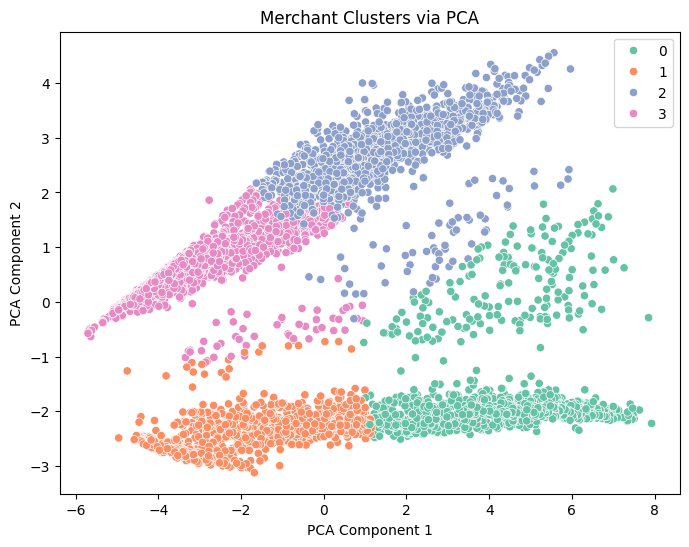

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Replace infinite values with NaN
final_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop datetime columns if not needed
final_data = final_data.drop(columns=['first_subscription_date', 'latest_date', 'first_charge_date'], errors='ignore')

# Then fill
final_data.fillna(0, inplace=True)


# Drop leaky and ID/date columns
leaky_cols = [
     'subscription_status', 
    'subscription_volume_30d', 'subscription_volume_lifetime', 
    'days_to_subscription'
]
features_to_drop = leaky_cols + ['merchant']
data = final_data.drop(columns=features_to_drop)

# Separate target
target = final_data['subscription_status']
X = data.copy()

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Build preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Preprocess features
X_preprocessed = preprocessor.fit_transform(X)
X_dense = X_preprocessed.toarray()

# ----------------------
# CLUSTERING
# ----------------------

# PCA + Clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_dense)

final_data['segment_id'] = clusters

# Save cluster plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='Set2')
plt.title("Merchant Clusters via PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")


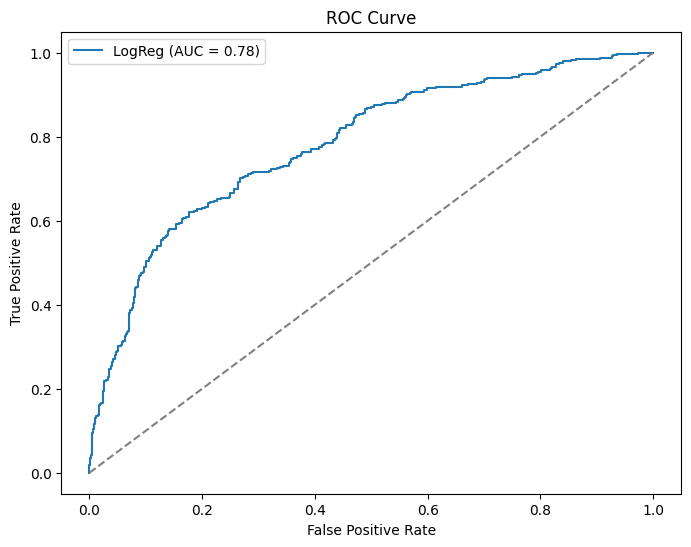

In [10]:
# ----------------------
# PROPENSITY MODELING
# ----------------------

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_dense, target, test_size=0.2, stratify=target, random_state=42
)

# Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LogReg (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

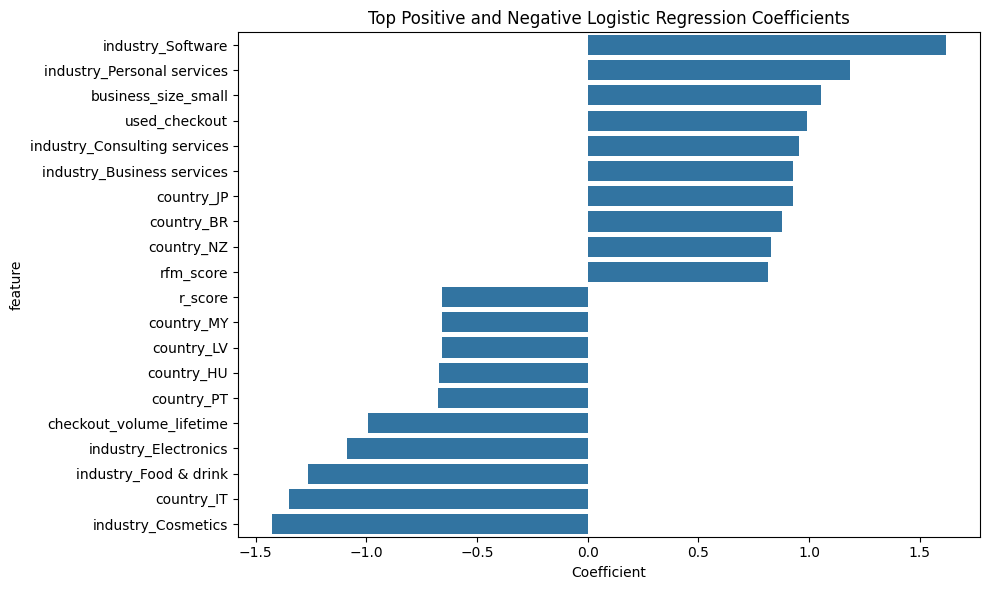

,feature,coef
44,industry_Software,1.619301
41,industry_Personal services,1.185005
21,business_size_small,1.052295
1,used_checkout,0.990989
27,industry_Consulting services,0.953128
23,industry_Business services,0.928831
74,country_JP,0.926131
54,country_BR,0.876194
83,country_NZ,0.825814
19,rfm_score,0.815643


In [11]:
# Fix: Define 'feature_names' and 'coefs' before using them

# Extract feature names from the preprocessor pipeline
feature_names = numeric_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))

# Extract coefficients from the trained logistic regression model
coefs = log_reg.coef_[0]

# Create importance DataFrame
importance_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})

# Sort by actual coefficient (not absolute value)
importance_df = importance_df.sort_values(by='coef', ascending=False)

# Select top 20 (10 positive, 10 negative, or tweak as needed)
top_features = importance_df.head(10)
bottom_features = importance_df.tail(10)
combined_df = pd.concat([top_features, bottom_features])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_df, x='coef', y='feature')
plt.title("Top Positive and Negative Logistic Regression Coefficients")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

combined_df


 Logistic Regression Performance (Threshold = 0.6)

Confusion Matrix:
[[684 137]
 [132 203]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       821
           1       0.60      0.61      0.60       335

    accuracy                           0.77      1156
   macro avg       0.72      0.72      0.72      1156
weighted avg       0.77      0.77      0.77      1156

Accuracy:  0.7673
Precision: 0.5971
Recall:    0.6060
F1 Score:  0.6015
ROC AUC:   0.7820


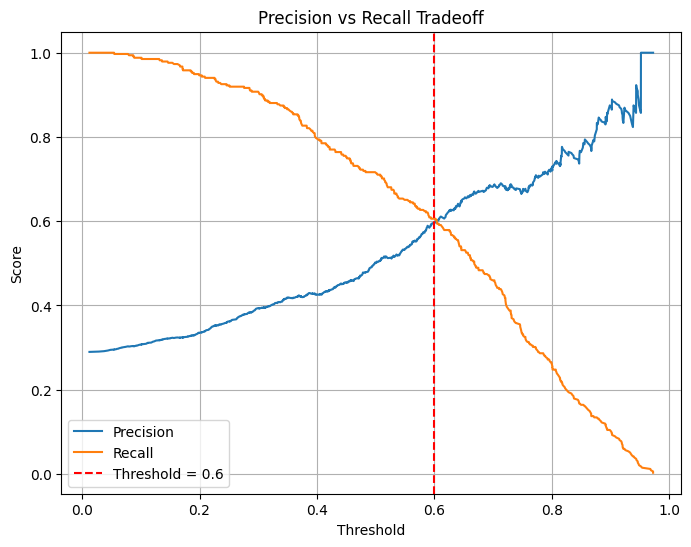

In [12]:
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)

# Choose classification threshold
threshold = 0.6
y_pred_class = (y_pred_prob >= threshold).astype(int)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred_class)
class_report = classification_report(y_test, y_pred_class)

# Print results to console
print(f"\n Logistic Regression Performance (Threshold = {threshold})\n")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall Tradeoff')
plt.axvline(threshold, linestyle='--', color='red', label='Threshold = 0.6')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Score all merchants
full_scores = log_reg.predict_proba(X_dense)[:, 1]
final_data['propensity_score'] = full_scores

# Filter non-subscribers and select top 10%
non_subs = final_data[final_data['subscription_status'] == 0]

# Sort by propensity score and select top 10%
threshold = non_subs['propensity_score'].quantile(0.90)

top_targets = non_subs[non_subs['propensity_score'] >= threshold][[
    'merchant', 'propensity_score', 'segment_id'
]]

top_targets = top_targets.sort_values(by='propensity_score', ascending=False)

top_targets

,merchant,propensity_score,segment_id
1970,acd6d4fa,0.965390,2
4251,61f9a12c,0.959073,2
2651,fa18d040,0.951565,2
1304,5247385c,0.943353,0
5257,c16d261a,0.938046,3
...,...,...,...
2572,de25f086,0.689654,2
1538,52934649,0.689505,2
1204,5948dccd,0.689325,0
763,aee2bb1f,0.689244,2


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=16becd37-ae40-4707-8bb9-d82daeafcb0e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>